In [1]:
import numpy as np       # operations on numerical arrays
import math as m
import operator          # for sorting list of class instances
from scipy import stats
import datetime as dt
from   dateutil import parser 


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib as mpl

from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

from IPython.display import display, Markdown, Latex

#NLP modules!
import nltk  as nl
import spacy as sp
spnlp = sp.load("en_core_web_sm") # set spacy to English
from collections import Counter
import re

#import gensim

# BH core routines for .csv files exported from Mappedometer
import runData as rd


def testdata(N):
    listofruns = []
    day1 = parser.parse('15-Oct-2015')
    for i in range(N):
        date = day1 + dt.timedelta(days=i)
        pace = 300
        t = 3.9*pace
        stcomment = '{:}F.aword'.format(i)
        if i>N/2:
            stcomment = '{:}F'.format(i)
        r = rd.run(date, pace, t, stcomment)
        listofruns.append(r)
    return listofruns

In [2]:
##   Peter Norvig's spelling corrector
# http://norvig.com/spell-correct.html
# import re
# from collections import Counter

def getwords(text): return re.findall(r'\w+', text.lower())

#WORDS = Counter(getwords(open('big.txt').read()))
WORDS = Counter(spnlp.vocab.strings)

#def P(word, N=sum(WORDS.values())): 
def P(word, N=sum(WORDS.values())):
    "Probability of `word`."
    return WORDS[word] / N


print("Vocab has {:} words.".format(len(WORDS.values())))
twds = ['integral', 'aslkjerwoieu', 'cosolodation', 'lake','Lake', 'Wash','wash']
for wt in twds:
    print('P('+wt+') = {:}'.format(P(wt))) 



def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

Vocab has 83431 words.
P(integral) = 1.198595246371253e-05
P(aslkjerwoieu) = 0.0
P(cosolodation) = 0.0
P(lake) = 1.198595246371253e-05
P(Lake) = 1.198595246371253e-05
P(Wash) = 1.198595246371253e-05
P(wash) = 1.198595246371253e-05


In [3]:
rund = rd.runLists()
rund.reader()
#rund.allruns = testdata(20)

fused = re.compile(r'(\w+)[,\.](\w*)') # eg '50F.cool'
rcoms = []
pace_avg = 0.0
for r in rund.allruns:
    pace_avg += r.pace
    doc = spnlp(r.comment)
    t2l = []
    for t in doc:  # get tokens in this run
       # print('   token:',t.text)
        if (not t.is_stop) and (not t.is_punct):
            # find and split fused tokens
            #matches = [m for m in re.finditer(fused,t.text)]
            match = re.search(fused,t.text)
            if match:
                t1 = spnlp(match.group(1))
                t2 = spnlp(match.group(2))
                for t in [t1, t2]:
                    if len(t)>0:
                        t2l.append(t[0]) 
            else:
                t2l.append(t) #make a list of tokens
    rcoms.append(t2l)     # a list of token lists
nts = [7,14]
for nt in nts:
    print('token ',nt,' has:')
    for t in rcoms[nt]:
        print('    token.text: ',t.text)
pace_avg /= len(rund.allruns)


token  7  has:
    token.text:  72F
    token.text:  cloudy
    token.text:  11:45AM
    token.text:   
    token.text:  20th
    token.text:  75th
token  14  has:
    token.text:  78F
    token.text:  sunny
    token.text:  11:00AM
    token.text:  Consolidation


In [4]:
 
verbs = []
nouns = []
words = []
temps = []
times = []
anlonly = re.compile('[^0-9a-zA-Z]*')
atemperature = re.compile(r'[0-9]+\s*[fF]')
atime = re.compile(r'[0-9]{1,2}:[0-9]{2}\s*(am|pm|\s*)')
hascomma = re.compile(r'[0-9]+[fF]\S')

for i,rctd in enumerate(rcoms):
    for t in rctd:  # the tokens for each run 
        if hascomma.match(t.text):
            print('token ',i,' has comma:',t.text)
        w1 = anlonly.sub('',t.text).lower()
        w = w1
        if P(w1) < 0.5e-08 :
            w = correction(w1)
     #   print('{:}->{:}->{:}'.format(t.text,w1,w))        
        if atemperature.match(w1):
            temps.append(w1)
        if atime.match(t.text):
            times.append(t.text.lower())
        if len(w) > 1:
            words.append(w)      
        if t.pos_ == "NOUN":
            nouns.append(w)
        if t.pos_ == "VERB":
            verbs.append(w)


WORDS=Counter(words)

print("Vocab has {:} words.".format(len(WORDS.values())))
wt = 'integral'
print('P('+wt+') = {:}'.format(P(wt)))
wt = 'adkjfaooruxcc'
print('P('+wt+') = {:}'.format(P(wt)))
wt='consolodation'
print('P('+wt+') = {:}'.format(P(wt)))
wt='the'
print('P('+wt+') = {:}'.format(P(wt)))
wt='house'
print('P('+wt+') = {:}'.format(P(wt)))


wf = Counter(words)
vf = Counter(verbs)
nf = Counter(nouns)
tf = Counter(temps)
tif = Counter(times)

print('I found {:3} unique words'.format(len(wf.keys())))
print('   10 most common are:')
print('   ',wf.most_common(10))
print('')
print('I found {:3} unique verbs'.format(len(vf.keys())))
print('   10 most common are:')
print('   ',vf.most_common(10))
print('')
print('I found {:3} unique nouns'.format(len(nf.keys())))
print('   10 most common are:')
print('   ',nf.most_common(10))
print('')
print('I found {:3} unique temperatures'.format(len(tf.keys())))
print('   10 most common are:')
print('   ',tf.most_common(10))
print('')
print('I found {:3} unique times'.format(len(tif.keys())))
print('   10 most common are:')
print('   ',tif.most_common(10))
print('')

Vocab has 918 words.
P(integral) = 0.0
P(adkjfaooruxcc) = 0.0
P(consolodation) = 0.0
P(the) = 0.0
P(house) = 1.198595246371253e-05
I found 918 unique words
   10 most common are:
    [('sunny', 178), ('start', 142), ('strong', 131), ('good', 107), ('cloudy', 100), ('consolidation', 81), ('lo', 56), ('took', 53), ('mo', 51), ('easy', 48)]

I found 118 unique verbs
   10 most common are:
    [('took', 53), ('sign', 38), ('felt', 35), ('start', 28), ('run', 14), ('turn', 12), ('5th', 8), ('hamstring', 6), ('started', 4), ('lost', 3)]

I found 368 unique nouns
   10 most common are:
    [('start', 112), ('consolidation', 79), ('mo', 48), ('weightsymca', 47), ('weights', 34), ('5th', 32), ('caf', 31), ('push', 30), ('effort', 26), ('lo', 25)]

I found  55 unique temperatures
   10 most common are:
    [('50f', 40), ('48f', 35), ('60f', 32), ('65f', 31), ('45f', 29), ('56f', 17), ('55f', 17), ('44f', 15), ('42f', 15), ('70f', 14)]

I found  96 unique times
   10 most common are:
    [('4:30p

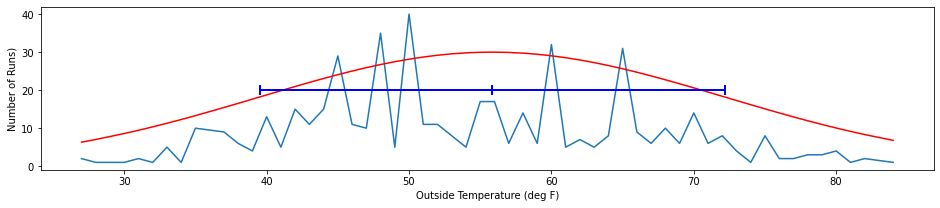

In [5]:
ts = sorted(tf.keys())
tnums = []
tfreqs = []
tot_sect = 0
tot_sect2 = 0
tmax = -99999
for t in ts:
  #  print('{:5} {:}'.format(t,tf[t]))
    temper = float(t.replace('f',''))
    tnums.append(temper)
    tfreqs.append(tf[t])

    # build mean and SD values
    tot_sect += temper
    tot_sect2 += temper*temper 
    
###
# Compute the stats
n = len(ts)
avg_temp = tot_sect/n
sd_temp  = np.sqrt(
    (n*tot_sect2-tot_sect*tot_sect) / (n*(n-1))
    ) 

plt.figure(2,figsize=(16,3))
plt.plot(tnums,tfreqs)
# plot the normal distribution
nd = stats.norm.pdf(tnums, avg_temp, sd_temp)
y = 0.75*np.max(tfreqs)*nd/np.max(nd)   #auto scale height of normal dist.
plt.plot(tnums, y, 'r')
rd.plotHbar(avg_temp-sd_temp,avg_temp+sd_temp, 0.5*np.max(tfreqs),plt)
plt.xlabel('Outside Temperature (deg F)')
plt.ylabel('Number of Runs)')
plt.show()

In [6]:
sleepwake = ['tired', 'rest', 'night', 'sleep']
bad = ['weak', 'pain', 'hurts', 'hurt', 'bad', 'poor', 'blah', 'meh', 'bad']
weather_good = ['weather', 'sunny', 'pleasant', 'warm']
weather_bad  = ['weather','rain', 'wet', 'smoke', 'snow', 'ice', 'cool', 'drizzle', 'thunder','fog']
body = ['legs','arms','knee','leg','hamstring', 'foot', 'ball', 'heel', 'body', 'ham']
weightroom = ['weights', 'ymca', 'y', 'weightsymca','workout', 'lifting']
health = ['gerd','hurt','cold', 'pain', 'stiff', 'stiffness','sore']
effort = ['se','effort','push','pushed','tried', 'sustainable', 'motivation']
loweffort = ['consolidation', 'blah', 'meh', 'lo','low']

classes = {}
classes['sleepwake'] = sleepwake
classes['caf'] = ['caf','caffeine','coffee']
classes['bad'] = bad
classes['good'] = ['good','strong','fast','great','decent']
classes['weather_good'] = weather_good
classes['weather_bad'] = weather_bad
classes['body'] = body
classes['health'] = health
classes['weightroom'] = weightroom
classes['effort'] = effort
classes['loweffort'] = loweffort
classes['negative'] = ['bad','slow','weak','lo','low','sluggish','blah','meh']
classes['resume'] = ['back','break','trip','travel','gap']

In [7]:
print('matching runs: ')

classscores = {}  # define and zero out data dicts
classpaces = {}
for c in classes.keys():
    classscores[c] = 0
    classpaces[c] = 0.0
    
n=0
for i,r in enumerate(rund.runs):
    for wt in rcoms[i]:     # word tokens in each comment doc.
        if atemperature.match(wt.text):
            r.tempDegF = wt.text
      #  if P(wt.text)<1.0e-4:
      #      rwc = correction(wt.text)
      #  else:
        rwc = correction(wt.text)
      #  rwc = wt.text
        for c in classes.keys():  
                if rwc in classes[c]:
                    classpaces[c] += r.pace
                    classscores[c] += 1

print('characteristics of runs:')
for c in classes.keys():
    if classscores[c] > 0:
        avg = classpaces[c]/classscores[c]
    else:
        avg = 0.0
    print('   {:15} appears in {:3} runs. Avg pace diff: {:5.2f}'.format(c, classscores[c],avg-pace_avg))

matching runs: 
characteristics of runs:
   sleepwake       appears in  32 runs. Avg pace diff:  4.58
   caf             appears in  49 runs. Avg pace diff:  0.05
   bad             appears in  34 runs. Avg pace diff:  5.01
   good            appears in 259 runs. Avg pace diff:  2.04
   weather_good    appears in 191 runs. Avg pace diff: -2.26
   weather_bad     appears in  70 runs. Avg pace diff:  0.26
   body            appears in  59 runs. Avg pace diff:  1.23
   health          appears in  46 runs. Avg pace diff:  3.84
   weightroom      appears in  37 runs. Avg pace diff: -10.03
   effort          appears in  61 runs. Avg pace diff:  1.48
   loweffort       appears in 601 runs. Avg pace diff: -2.58
   negative        appears in 559 runs. Avg pace diff: -3.12
   resume          appears in  19 runs. Avg pace diff: -1.73


In [8]:

string = '50F.good'
regex_with_3_groups=r"([a-z])([0-9]+)([A-Z])"
for match in re.finditer(fused, string):
    for idx in range(3):
        print(idx, match.span(idx), match.group(idx))

0 (0, 8) 50F.good
1 (0, 3) 50F
2 (4, 8) good
